In [ ]:
from azure.storage.blob import BlobServiceClient
import pandas as pd

# Connect to Azure Blob Storage
connection_string = "DefaultEndpointsProtocol=https;AccountName=frauddetectionstorage1;AccountKey=your_account_key_here;EndpointSuffix=core.windows.net"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client("fraud-data")

# Download the dataset
blob_client = container_client.get_blob_client("creditcard.csv")
with open("creditcard.csv", "wb") as download_file:
    download_file.write(blob_client.download_blob().readall())

# Load the dataset into a DataFrame
data = pd.read_csv("creditcard.csv")
print(data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [2]:
print(data.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (227845, 30)
Testing set shape: (56962, 30)


In [5]:
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

# Upload the files to Azure Blob Storage
for file in ["X_train.csv", "X_test.csv", "y_train.csv", "y_test.csv"]:
    with open(file, "rb") as data:
        container_client.upload_blob(name=file, data=data)

In [ ]:
from azure.storage.blob import BlobServiceClient
import pandas as pd

# Replace with your actual connection string
connection_string = "DefaultEndpointsProtocol=https;AccountName=frauddetectionstorage1;AccountKey=your_account_key_here;EndpointSuffix=core.windows.net"

# Connect to Azure Blob Storage
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client("fraud-data")

# Download the preprocessed data
for file in ["X_train.csv", "X_test.csv", "y_train.csv", "y_test.csv"]:
    blob_client = container_client.get_blob_client(file)
    with open(file, "wb") as download_file:
        download_file.write(blob_client.download_blob().readall())

# Load the data into DataFrames
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

# Ensure y_train and y_test are 1D arrays (required for scikit-learn)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (227845, 30)
Testing set shape: (56962, 30)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=5000)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Calculate evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC-ROC:", roc_auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Precision: 0.8484848484848485
Recall: 0.5714285714285714
F1-Score: 0.6829268292682927
AUC-ROC: 0.9749430793701837
Confusion Matrix:
 [[56854    10]
 [   42    56]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.57      0.68        98

    accuracy                           1.00     56962
   macro avg       0.92      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962



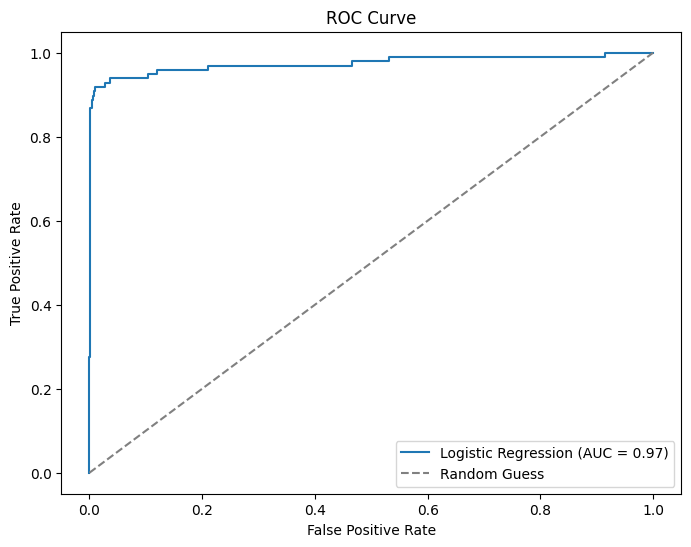

In [14]:
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [15]:
import joblib

# Save the model locally
model_filename = "logistic_regression_model.pkl"
joblib.dump(model, model_filename)

# Upload the model to Azure Blob Storage
blob_client = container_client.get_blob_client(model_filename)
with open(model_filename, "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

print("Model saved and uploaded to Azure Blob Storage.")

Model saved and uploaded to Azure Blob Storage.
